# Prerequisite: Import Required Libraries

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import csv
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import PIL
import seaborn as sns
import tkinter as tk

from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from skimage import color, data, exposure
from matplotlib.image import imread

from tensorflow import keras
from PIL import ImageTk
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tkinter import *
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.models import load_model
from tensorflow.keras.optimizers import SGD

np.random.seed(42)

%matplotlib inline

from matplotlib import style
style.use('fivethirtyeight')


# Dataset Path
DATA_DIR = './Datasets/TSRD/'
TRAIN_PATH = DATA_DIR + 'Train/'
TEST_PATH = DATA_DIR +'Test/'
EXTERNAL_TEST_PATH = DATA_DIR + 'External_Test/'

# Setting the image dimentions to 30x30x3
IMG_SIZE = 30
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
channels = 3

ModuleNotFoundError: No module named 'cv2'

### Mapping Sign Names to Classes

In [67]:
#map sign name to classes
labels_dict = None
with open('mapSignnamesToClass.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None)
    labels_dict = {int(rows[0]):rows[1] for rows in reader}
    
print(labels_dict)

{0: 'Speed limit (5km/h)', 1: 'Speed limit (15km/h)', 2: 'Speed limit (30km/h)', 3: 'Speed limit (40km/h)', 4: 'Speed limit (50km/h)', 5: 'Speed limit (60km/h)', 6: 'Speed limit (70km/h)', 7: 'Speed limit (80km/h)', 8: 'Driving straight ahead or turning left prohibited', 9: 'Driving straight ahead or turning right prohibited', 10: 'Driving straight ahead prohibited', 11: 'Turning left prohibited', 12: 'Turning left or right prohibited', 13: 'Turning right prohibited', 14: 'Overtaking prohibited', 15: 'Turning around prohibited', 16: 'Cars prohibited', 17: 'Using the horn prohibited', 18: 'End of speed limit (40km/h)', 19: 'End of speed limit (50km/h)', 20: 'Driving straight ahead or turning right mandatory', 21: 'Driving straight ahead mandatory', 22: 'Turning left mandatory', 23: 'Turning left or right mandatory', 24: 'Turning right mandatory', 25: 'Passing left mandatory', 26: 'Passing right mandatory', 27: 'Mandatory direction of the roundabout', 28: 'Mandatory lane for cars', 29: '

### Total Classes

In [68]:
Train_annotation = pd.read_csv(f'{DATA_DIR}/Train.txt', delimiter=';', header=None)
Test_annotation = pd.read_csv(f'{DATA_DIR}/Test.txt' , delimiter=';', header=None)

# 8th column is Category Code
NUM_CATEGORIES = Train_annotation[7].value_counts().count()
NUM_CATEGORIES

58

# Step 1: Load The Data

## Fetch Training Data & Resizing

In [69]:
# Step 1: Load The Data
# Fetch Training Data & Resizing

image_data = []
image_labels = []

path = TRAIN_PATH
images = os.listdir(path)

for img in images:

    #skip macOS hidden file
    if(img.split('_')[0] == '.DS'):
        continue
        
    # Obtain image's class
    i = int(img.split('_')[0])
    try:
        image = cv2.imread(path + '/' + img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = PIL.Image.fromarray(image, 'RGB')
        image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        
        # STORE IMAGE AND IT'S LABEL
        image_data.append(np.array(image))
        image_labels.append(i)
    except:
        print("Error in " + img)

# CONVERT INTO NUMPY ARRAY
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(4170, 30, 30, 3) (4170,)


## Fetch Test Data & Resizing

In [70]:
#Fetch Test Data & Resizing

test_labels = Test_annotation[7].values
test_images = Test_annotation[0].values

path = TEST_PATH

data =[]

for img in test_images:
    try:
        image = cv2.imread(path + img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = PIL.Image.fromarray(image, 'RGB')
        image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(image))
    except:
        print("Error in " + img)

#Converting the test data to numpy array
X_test = np.array(data)

X_test.shape

(1994, 30, 30, 3)

## Shuffle training data
- Reduce Order Bias
    - The network might start learning patterns that are specific to the order of the data
- Avoid Overfitting

In [71]:
shuffle_indexes = np.arange(image_data.shape[0])

# Seed added to ensure the same result is obtained every time
np.random.seed(5)
np.random.shuffle(shuffle_indexes)

image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Split data into training & validation set

In [72]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

#Freeing up unused memory
image_data = None
del image_data

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (3336, 30, 30, 3)
X_valid.shape (834, 30, 30, 3)
y_train.shape (3336,)
y_valid.shape (834,)


## One hot encoding the labels
- Represent all classes with numerical value

In [73]:
#Saving the old y_train and y_val for future use
y_train_old = np.copy(y_train)
y_val_old = np.copy(y_val)

y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(3336, 58)
(834, 58)


# Step 2: Data Summary & Exploratory Data Analysis before Pre-Processing

## Data Size & Shape

In [74]:
# Step 2: Data Summary & Exploratory Data Analysis before Pre-Processing

n_train = len(X_train)

n_valid = len(X_val)

n_test = len(X_test)

image_shape = X_train.shape[1:]

labels_index = np.unique(y_train_old)
n_labels = len(labels_index)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of labels/classes =", n_labels)

Number of training examples = 3336
Number of validation examples = 834
Number of testing examples = 1994
Image data shape = (30, 30, 3)
Number of labels/classes = 58


### Image & Label Sample

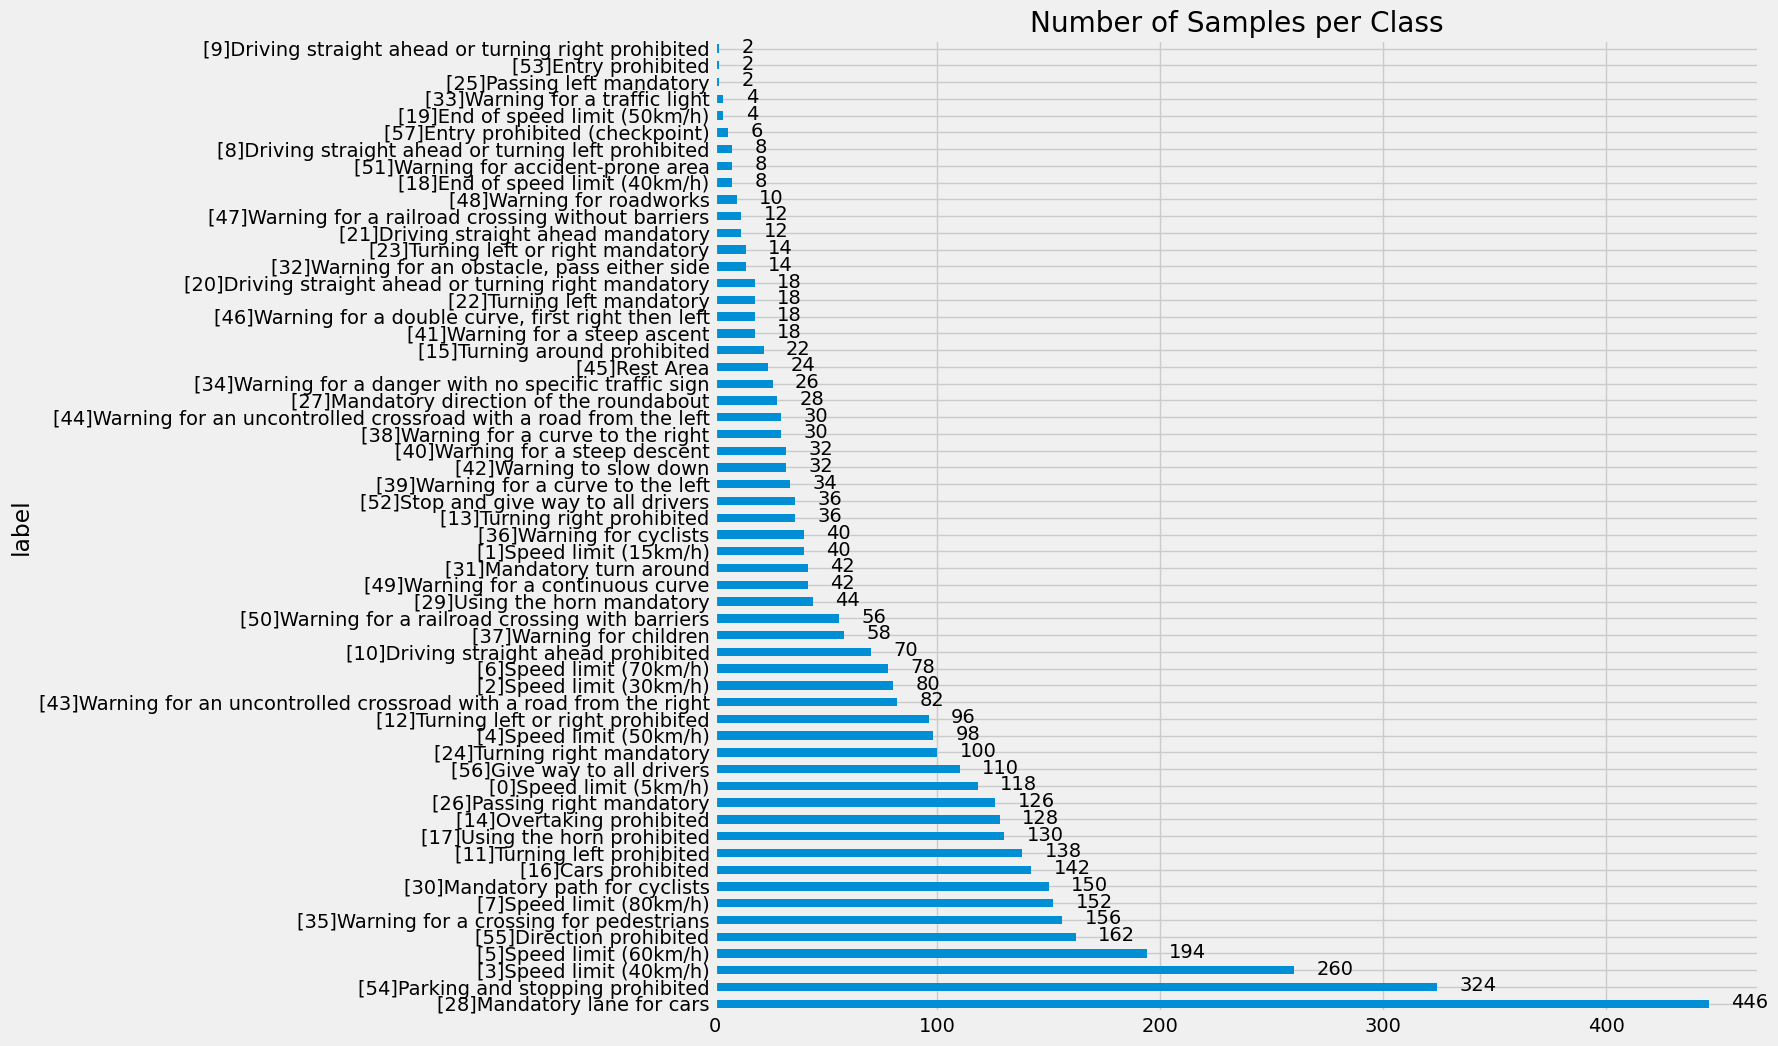

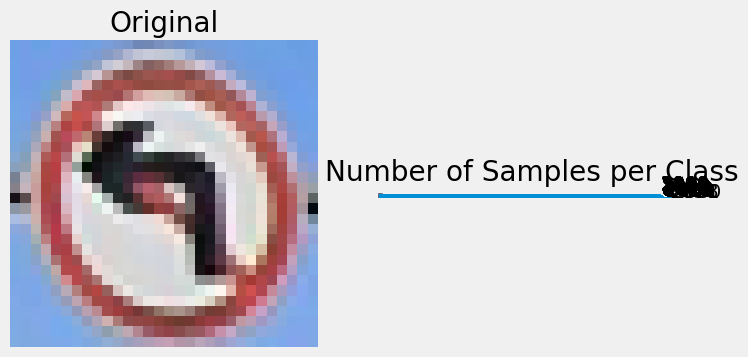

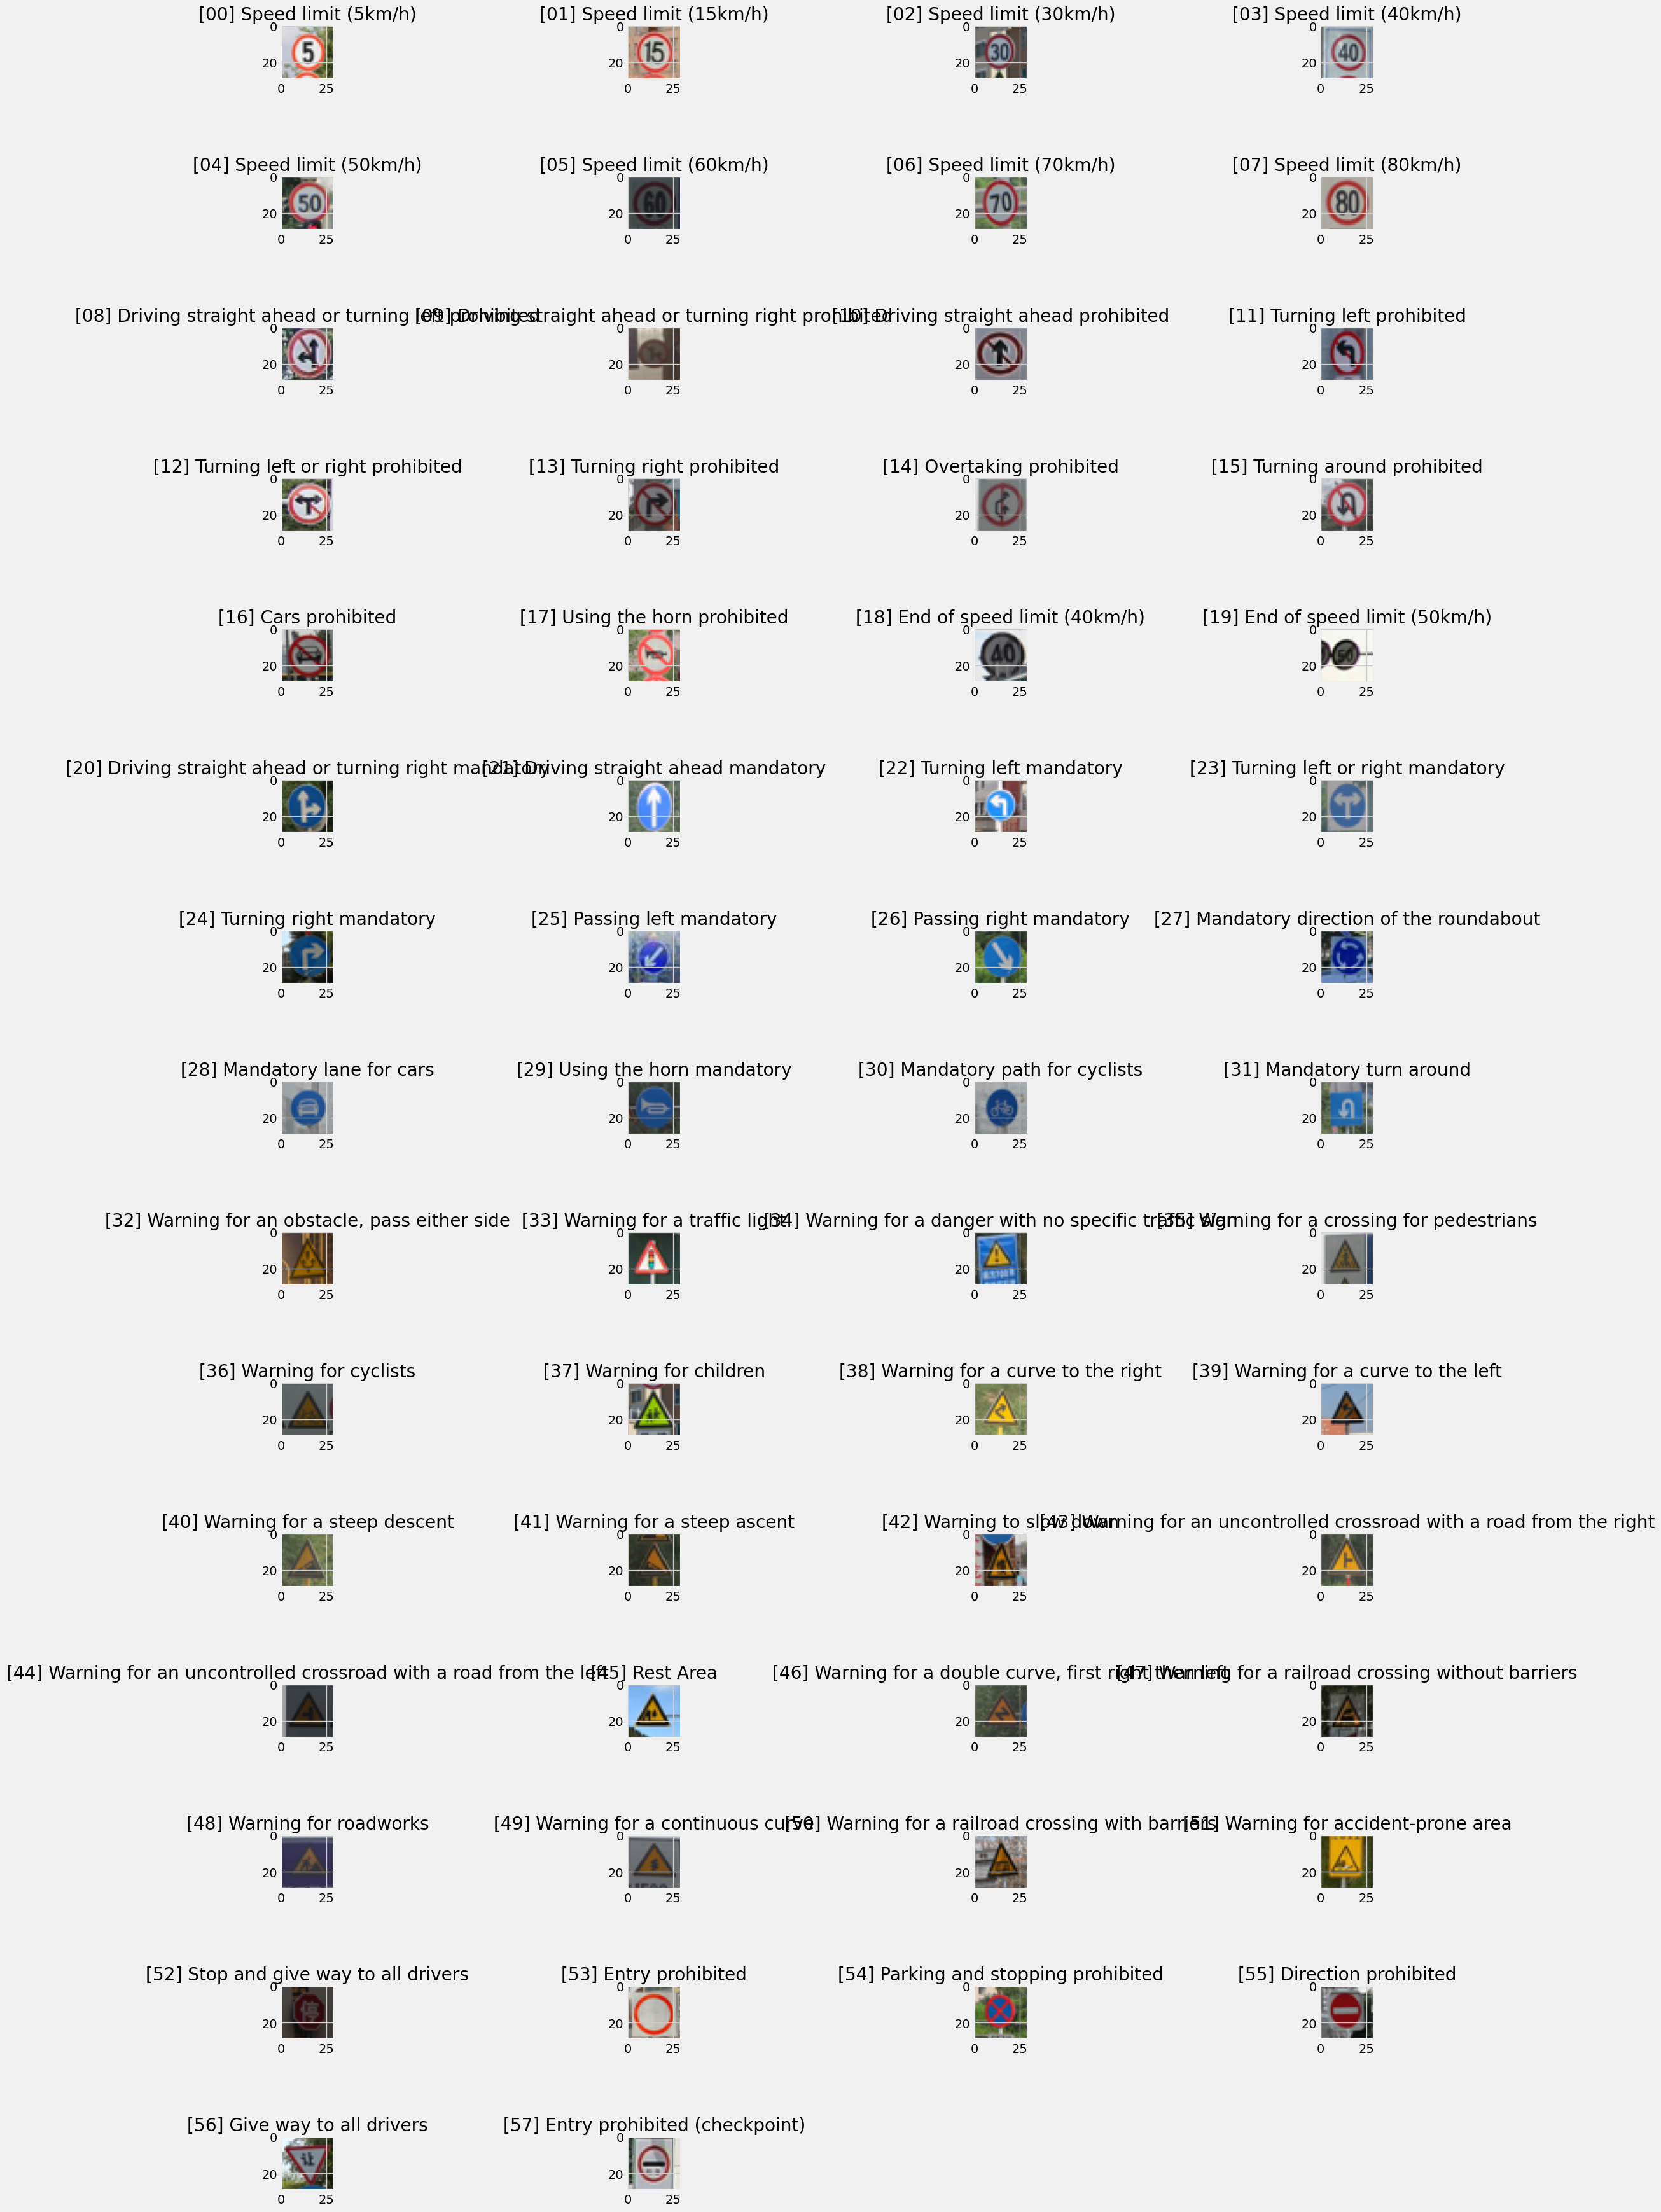

In [75]:
fig = plt.figure(figsize=(22,35), tight_layout={'h_pad':5})

for i in range(NUM_CATEGORIES):
    image_key = np.where(y_train_old==i)[0][0]
    img = X_train[image_key]
    ax = fig.add_subplot(int(NUM_CATEGORIES/4)+1,4,i+1) 
    ax.imshow(img)
    plt.title("[%02d] %s" % (i, labels_dict[y_train_old[image_key]]))
plt.show()

### Class Distribution

In [76]:
## Display label distribution in a barchart

y_train_df = pd.DataFrame()
y_val_df = pd.DataFrame()
y_train_df['label'] = y_train_old
y_val_df['label'] = y_val_old
y_data_df = pd.concat([y_train_df, y_val_df])
ax = y_data_df['label'].value_counts().plot(kind='barh', figsize = (12,12), title='Number of Samples per Class')
index_list = y_data_df['label'].value_counts().index.tolist()
ax.set_yticklabels(list(map(lambda x: f'[{x}]{labels_dict[x]}', index_list)))
for i, v in enumerate(y_data_df['label'].value_counts()):
    ax.text(v + 10, i - 0.25, str(v), color='black')

In [77]:
labels_i = [[i, sum(y_train_old == i)] for i in range(len(np.unique(y_train_old)))]

data_pd = pd.read_csv('mapSignnamesToClass.csv')
labels_pd = data_pd.set_index('ClassId')

labels_pd['Count'] = pd.Series(np.asarray(labels_i).T[1], index=np.asarray(labels_i).T[0])


labels_pd.sort_values(['Count'])

SignName  Count
ClassId                                                          
9        Driving straight ahead or turning right prohib...      1
53                                        Entry prohibited      2
25                                  Passing left mandatory      2
57                           Entry prohibited (checkpoint)      4
33                             Warning for a traffic light      4
19                             End of speed limit (50km/h)      4
18                             End of speed limit (40km/h)      7
51                         Warning for accident-prone area      8
8        Driving straight ahead or turning left prohibited      8
48                                   Warning for roadworks      8
23                         Turning left or right mandatory     10
22                                  Turning left mandatory     10
32               Warning for an obstacle, pass either side     11
21                        Driving straight ahead mandatory     11
47        Warning for a railroad crossing without barriers     12
20       Driving straight ahead or turning right mandatory     12
46       Warning for a double curve, first right then left     15
41                              Warning for a steep ascent     16
15                               Turning around prohibited     18
45                                               Rest Area     18
34       Warning for a danger with no specific traffic ...     20
27                   Mandatory direction of the roundabout     21
44       Warning for an uncontrolled crossroad with a r...     23
40                             Warning for a steep descent     24
38                        Warning for a curve to the right     25
36                                    Warning for cyclists     27
39                         Warning for a curve to the left     28
13                                Turning right prohibited     29
42                                    Warning to slow down     30
29                                Using the horn mandatory     31
52                        Stop and give way to all drivers     32
31                                   Mandatory turn around     33
1                                     Speed limit (15km/h)     35
49                          Warning for a continuous curve     38
50           Warning for a railroad crossing with barriers     41
37                                    Warning for children     45
10                       Driving straight ahead prohibited     60
6                                     Speed limit (70km/h)     65
2                                     Speed limit (30km/h)     65
43       Warning for an uncontrolled crossroad with a r...     69
24                                 Turning right mandatory     75
4                                     Speed limit (50km/h)     76
12                        Turning left or right prohibited     80
56                                 Give way to all drivers     81
0                                      Speed limit (5km/h)     93
14                                   Overtaking prohibited     97
17                               Using the horn prohibited     98
26                                 Passing right mandatory    106
11                                 Turning left prohibited    114
30                             Mandatory path for cyclists    119
16                                         Cars prohibited    119
35                  Warning for a crossing for pedestrians    123
55                                    Direction prohibited    127
7                                     Speed limit (80km/h)    132
5                                     Speed limit (60km/h)    153
3                                     Speed limit (40km/h)    202
54                         Parking and stopping prohibited    253
28                                 Mandatory lane for cars    366

# Step 3: Data Pre-processing

## Equalization and Contrast Enhancement
- Standardizing input to improve performance
- Enhance the contrast, so the edge more clearer and performance improved

In [78]:
# Function that applies equalization and local contrast enhancement
def equalize(image_data):
    '''Contrast Limited Adaptive Histogram Equalization (CLAHE).
    http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist
    '''
    
    norm = np.array([exposure.equalize_adapthist(image, kernel_size=3, clip_limit=0.1) for image in tqdm(image_data)])
    return norm

# Run the equalization process

print('\nEqualizing Start.\n')

print('Equalizing Training Images...')
X_train_norm = equalize(X_train)

print('Equalizing Validation Images...')
X_val_norm = equalize(X_val)

print('\nEqualizing Test Images...')
X_test_norm = equalize(X_test)

print('\nEqualizing Complete.')


Equalizing Start.

Equalizing Training Images...


100%|██████████████████████████████████████| 3336/3336 [00:05<00:00, 594.01it/s]


Equalizing Validation Images...


100%|████████████████████████████████████████| 834/834 [00:01<00:00, 595.92it/s]



Equalizing Test Images...


100%|██████████████████████████████████████| 1994/1994 [00:03<00:00, 606.65it/s]


Equalizing Complete.


## Data Augmentation
- Perform minor change to original data to produce new image
- Increase size of training set
- Make the distribution even accross the classes

### Random Transformations

In [79]:
# Transformations applied to RBG training images
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False
)

In [80]:
    ## Create AUGMENTED training sets

    max_images_per_class = 2000
    X_train_aug = np.empty((0, IMG_SIZE, IMG_SIZE, 3))
    y_train_aug = np.empty(0, dtype='uint8')

    print('Augmenting Images...')
    for i in tqdm(range(n_labels)):
        index = [y_train==i]
        i_class_images = X_train_norm[y_train_old==i]
        i_class_y = y_train_old[y_train_old==i]

        i_X_train_aug = np.copy(i_class_images)
        i_y_train_aug = np.copy(i_class_y)

        for X,y in datagen.flow(i_class_images, i_class_y, batch_size=len(i_class_y), seed=113+i*17):            
            i_X_train_aug = np.append(i_X_train_aug, X, axis=0)
            i_y_train_aug = np.append(i_y_train_aug, y, axis=0)

            if len(i_X_train_aug) >= max_images_per_class:
                break

        X_train_aug = np.append(X_train_aug, i_X_train_aug[:max_images_per_class], axis=0)
        y_train_aug = np.append(y_train_aug, i_y_train_aug[:max_images_per_class], axis=0)              

    X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=113)

    print('Augmentation Complete.\n')
    print('New number of training images: ', X_train_aug.shape[0])

Augmenting Images...


100%|███████████████████████████████████████████| 58/58 [00:37<00:00,  1.55it/s]


Augmentation Complete.

New number of training images:  116000


# Step 4: Data Summary & Exploratory Data Analysis after Pre-Processing

## Data Size & Shape after Pre-processing

In [81]:
## Verify final data splits

print("Number of training examples =", len(X_train_aug))
print("Number of validation examples =", len(X_val))
print("Number of test examples =", len(X_test))
print("Image data shape =", X_train_aug.shape[1:])
print("Number of labels/classes =", NUM_CATEGORIES)

Number of training examples = 116000
Number of validation examples = 834
Number of test examples = 1994
Image data shape = (30, 30, 3)
Number of labels/classes = 58


## Data Visualization after Pre-processing

### Comparison of Original vs Normalized Version

In [82]:
## Display original vs. normalized versions

index = random.randint(0, len(X_train_norm))

image_orig = X_train[index].squeeze()
image_norm = X_train_norm[index].squeeze()

plt.figure(figsize=(5,5))

plt.subplot2grid((1, 3), (0, 0));
plt.axis('off')
plt.title('Original')
plt.imshow(image_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 1));
plt.axis('off')
plt.title('Normalized')
plt.imshow(image_norm, cmap="gray")


print('label index: ', y_train_old[index])

label index:  24


### Image/Class Distribution

In [83]:
## Display label distribution in a histogram

y_train_df = pd.DataFrame()
y_val_df = pd.DataFrame()
y_train_df['label'] = y_train_aug
y_val_df['label'] = y_val_old
y_data_df = pd.concat([y_train_df, y_val_df])
ax = y_data_df['label'].value_counts().plot(kind='barh', figsize = (12,12), title='Number of Samples per Class')
ax.set_yticklabels(list(map(lambda x: labels_dict[x], y_data_df['label'].value_counts().index.tolist())))            
for i, v in enumerate(y_data_df['label'].value_counts()):
    ax.text(v + 10, i - 0.25, str(v), color='black')

# Step 5: Replace Original Training Set with Augmented Training Set

In [84]:
X_train = np.copy(X_train_aug)
y_train = np.copy(y_train_aug)
X_val = np.copy(X_val_norm)
X_test = np.copy(X_test_norm)

# Freeing up old memory
del X_train_norm
del X_val_norm
del X_test_norm
del X_train_aug
del y_train_aug

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (116000, 30, 30, 3)
X_valid.shape (834, 30, 30, 3)
y_train.shape (116000,)
y_valid.shape (834, 58)


In [85]:
# # One hot encoding new training set

y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)

print(y_train.shape)

(116000, 58)


# Step 6: Model Architecture

## Building the Model

In [86]:
#Layer of the models
model = keras.models.Sequential([    
    keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.7),
    
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
])

In [95]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001
epochs = 60

# Create Adam optimizer without 'decay' parameter
opt = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [96]:
#summary of the model
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 13, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 1, 1, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,314 (641.85 KB)

 Trainable params: 163,866 (640.10 KB)

 Non-trainable params: 448 (1.75 KB)

## Visualization of Model

In [97]:
#layered view of model
import visualkeras
visualkeras.layered_view(model)

AttributeError: 'Conv2D' object has no attribute 'output_shape'

## Training the Model

In [98]:
BATCH_SIZE = 16

In [99]:
from keras.callbacks import Callback
from keras.utils import to_categorical

class TestSetsCallback(Callback):
    def __init__(self, val_sets, batch_size=BATCH_SIZE):
        super().__init__()
        self.val_sets = val_sets
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for i, val_set in enumerate(self.val_sets):
            X_val, y_val = val_set
            test_loss, test_acc = model.evaluate(X_val, y_val,batch_size=self.batch_size,verbose=0)
            logs[f'test{i+1}_loss'] = test_loss
            logs[f'test{i+1}_accuracy'] = test_acc

# Test Set
test_sets = [(X_test, to_categorical(test_labels))]

# Create the multi-validation callback
test_sets_callback = TestSetsCallback(test_sets)

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(X_val, y_val),callbacks=[test_sets_callback])

Epoch 1/60
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 153s 21ms/step - accuracy: 0.8765 - loss: 0.3866 - val_accuracy: 0.9736 - val_loss: 0.0666 - test1_loss: 0.8117 - test1_accuracy: 0.7954
Epoch 2/60
3451/7250 ━━━━━━━━━━━━━━━━━━━━ 1:16 20ms/step - accuracy: 0.9364 - loss: 0.2029

In [ ]:
#plotting the graphs for accuracy
test_accuracy = np.array(history.history['test1_accuracy']);

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(test_accuracy[test_accuracy > 0.8], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Accuracy_Curve.png')
plt.show()


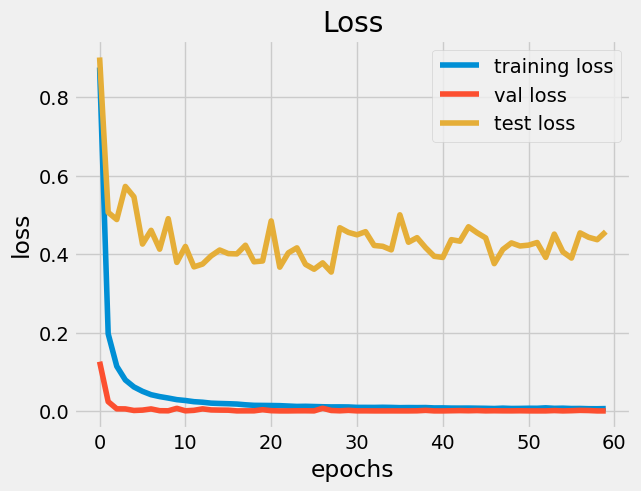

In [32]:
test_loss = np.array(history.history['test1_loss']);

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(test_loss[test_loss < 1], label='test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('Loss_Curve.png')
plt.show()


## Testing set Performance of Model

In [33]:
test = pd.read_csv(DATA_DIR + 'Test.txt' , delimiter=';', header=None)

labels = test[7].values
labels_test = test[7].value_counts().sort_index().index

# Predict test set image
pred=np.argmax(model.predict(X_test), axis=-1)

labels_pred = pd.DataFrame(pred)[0].value_counts().sort_index().index

result_labels = labels_test.append(labels_pred).value_counts().sort_index().index


#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

63/63 [==============================] - 0s 5ms/step
Test Data accuracy:  94.18254764292878


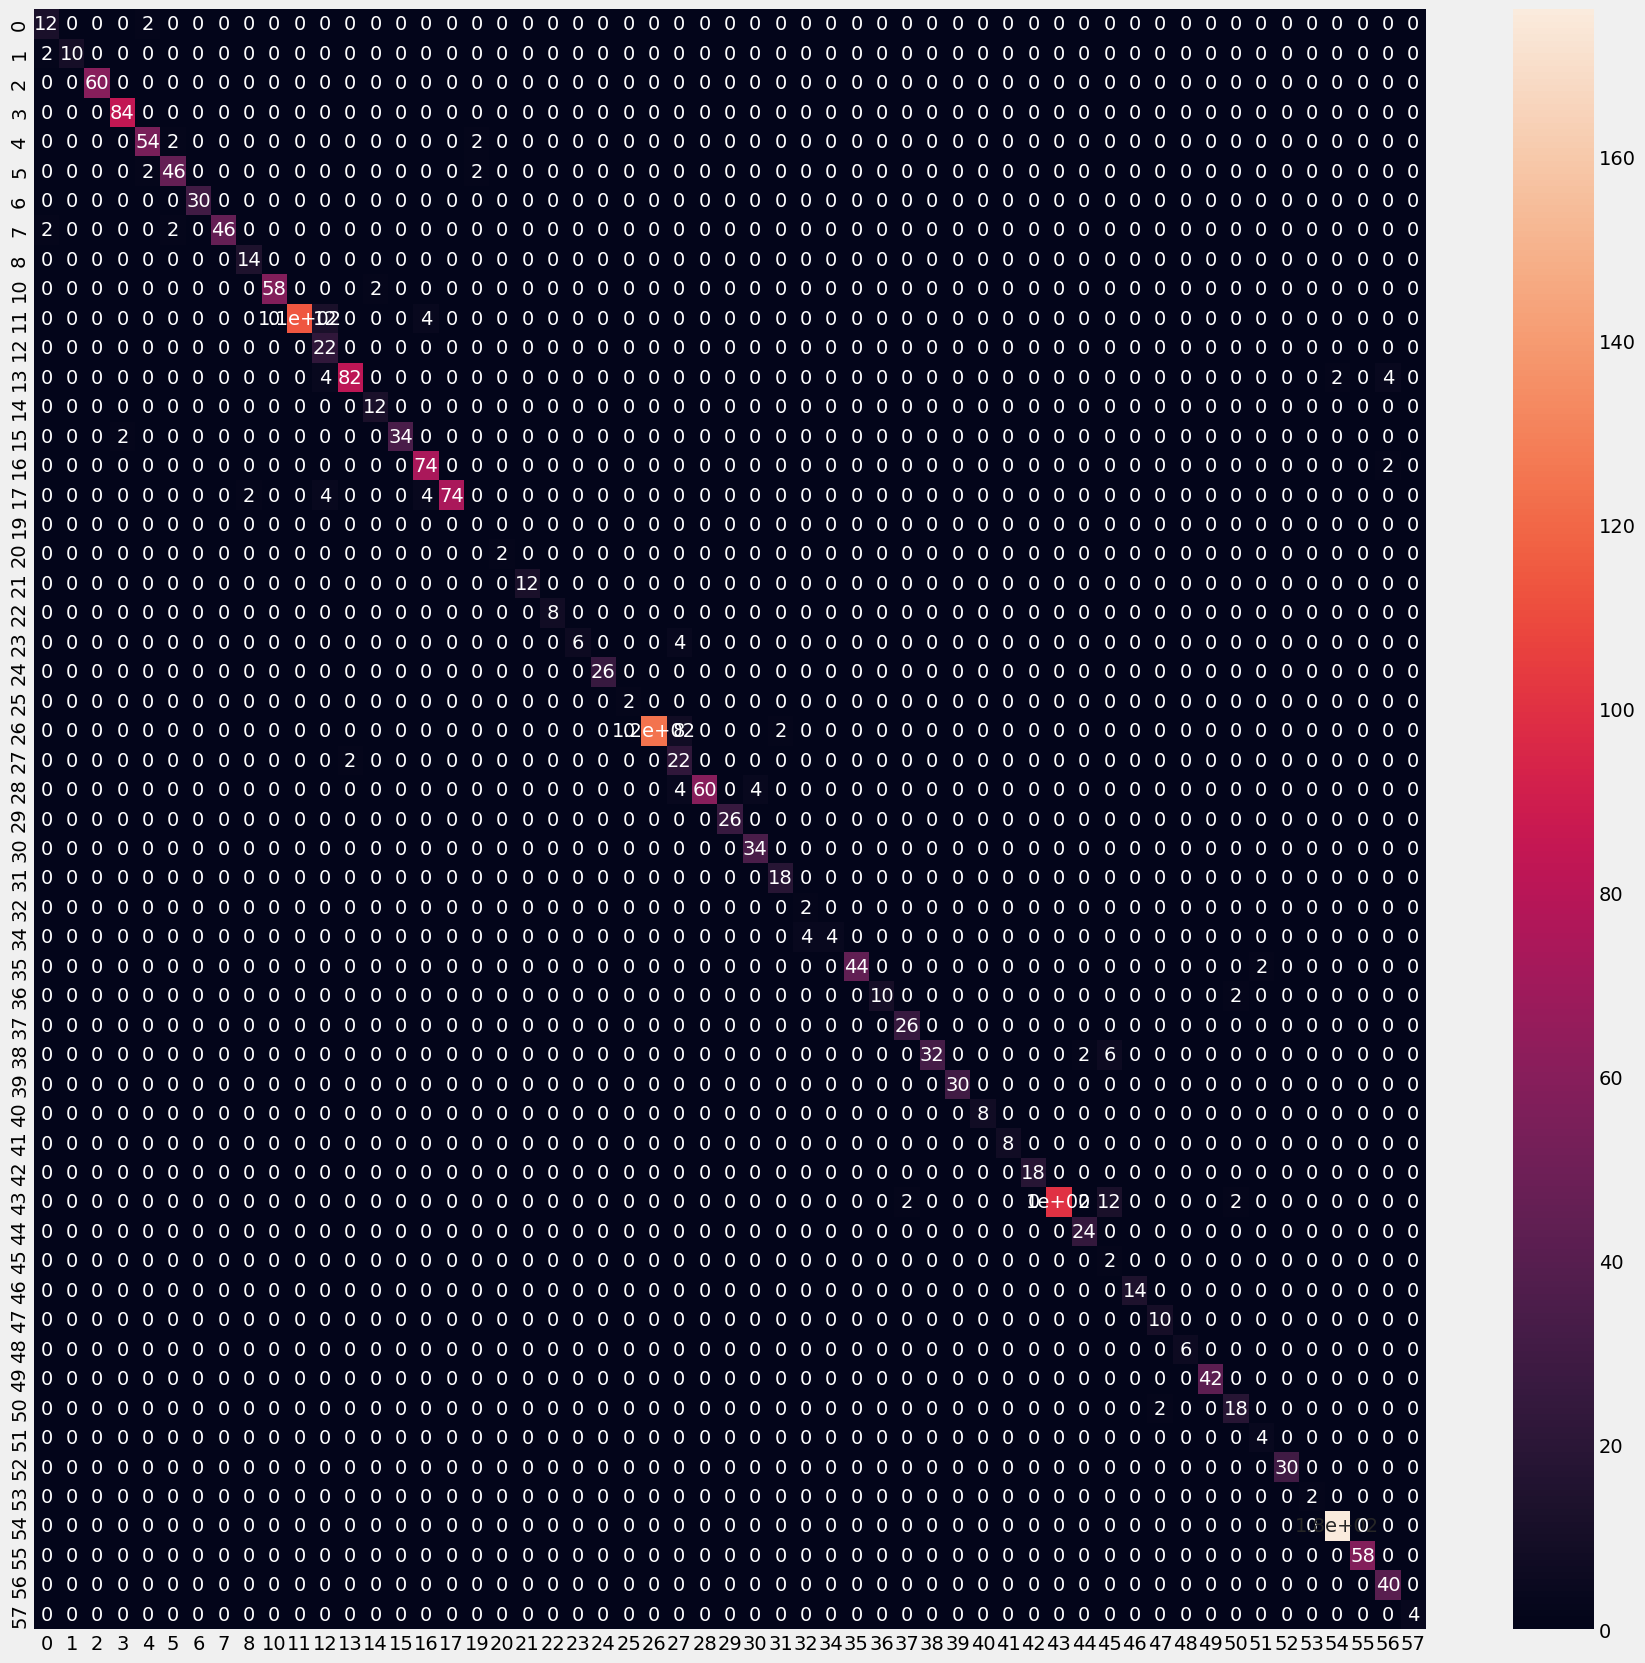

In [34]:
#confusion matrix
cf = confusion_matrix(labels, pred)
cf
#visualizing
labels_copy = labels_dict.copy()

#Remove class that does not exist in test set

labels_copy_keys = list(labels_copy.keys())

for i in range(len(labels_copy)):
    if i < len(result_labels):
        while(labels_copy_keys[i] != result_labels[i]):
            del labels_copy[labels_copy_keys[i]]
            del labels_copy_keys[i]



df_cm = pd.DataFrame(cf, index = labels_copy,  columns = labels_copy)
plt.figure(figsize = (20,20)) 
sns.heatmap(df_cm, annot=True)
plt.savefig('CM.png')

In [35]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       1.00      0.83      0.91        12
           2       1.00      1.00      1.00        60
           3       0.98      1.00      0.99        84
           4       0.93      0.93      0.93        58
           5       0.92      0.92      0.92        50
           6       1.00      1.00      1.00        30
           7       1.00      0.92      0.96        50
           8       0.88      1.00      0.93        14
          10       1.00      0.97      0.98        60
          11       1.00      0.88      0.93       130
          12       0.52      1.00      0.69        22
          13       0.98      0.89      0.93        92
          14       0.86      1.00      0.92        12
          15       1.00      0.94      0.97        36
          16       0.90      0.97      0.94        76
          17       1.00      0.88      0.94        84
          19       0.00    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Test which cannot classified correctly

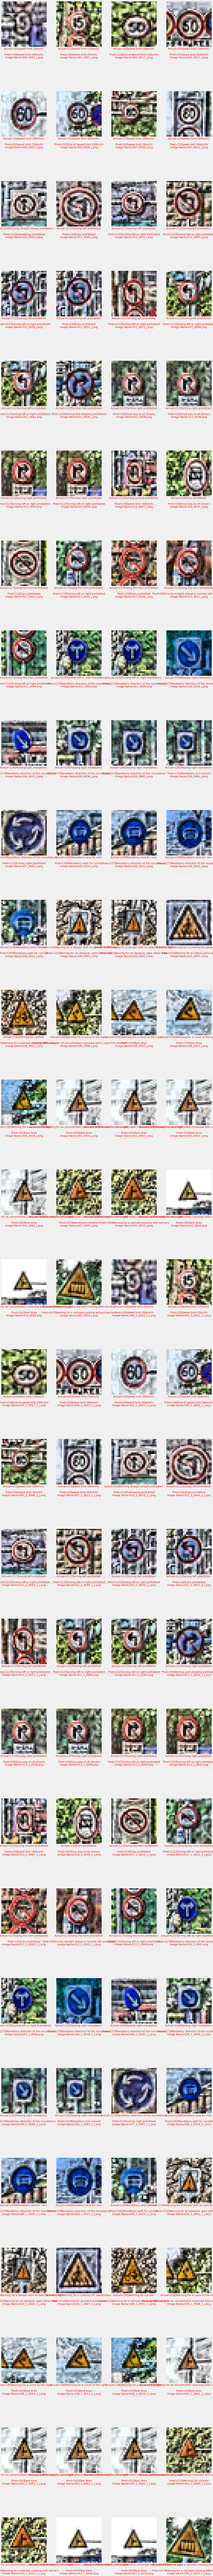

In [ ]:
start_index = 0
plotting_index = 0
plt.figure(figsize=(22, 300))
for i in range(len(X_test)):
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        plotting_index += 1
        plt.subplot(int((len(X_test) * (1 - accuracy_score(labels, pred)))/4)+1, 4, plotting_index)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        col = 'r'
        plt.xlabel('Actual=[{}]{} \n\n Pred=[{}]{} \nImage Name:{}'.format(actual, labels_dict[actual], prediction, labels_dict[prediction], test_images[i]), color = col)
        plt.imshow(X_test[start_index + i])
plt.show()

In [38]:
model.save("Model.h5")

# Testing with External Data Set
- Dataset: CATSD - https://github.com/icfaust/CATSAD/tree/main
- Reason of selection: It is Chinese Traffic Sign Dataset, matched with TSRD
- Missing Class: 33
- The dataset with class that not available in TSRD is removed
- the filename is renamed as xxx_i.png, xxx is the class code and i is index

In [39]:
# Fetch External Test Set
eTest_data = []
eTest_labels = []

path = EXTERNAL_TEST_PATH
images = os.listdir(path)

for img in images:
    #skip macOS hidden file
    if(img.split('_')[0] == '.DS'):
        continue
    # Obtain image's class
    i = int(img.split('_')[0])
    
    try:
        image = cv2.imread(path + '/' + img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = PIL.Image.fromarray(image, 'RGB')
        image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        
        # STORE IMAGE AND IT'S LABEL
        eTest_data.append(np.array(image))
        eTest_labels.append(i)
    except:
        print("Error in " + img)

# CONVERT INTO NUMPY ARRAY
eTest_data = np.array(eTest_data)
eTest_labels = np.array(eTest_labels)

X_etest = equalize(eTest_data)

100%|████████████████████████████████████| 55171/55171 [01:34<00:00, 581.34it/s]


1725/1725 [==============================] - 7s 4ms/step
Test Data accuracy:  81.87091044208007


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       981
           1       0.62      0.97      0.76       260
           2       0.75      0.78      0.77      1647
           3       0.91      0.82      0.86      3717
           4       0.85      0.83      0.84      1763
           5       0.88      0.79      0.83      3077
           6       0.82      0.95      0.88       726
           7       0.91      0.77      0.83      2276
           8       0.21      1.00      0.35        19
           9       0.01      0.01      0.01       224
          10       0.54      0.87      0.67       399
          11       0.91      0.82      0.87      1117
          12       0.35      0.93      0.51       153
          13       0.86      0.87      0.86       679
          14       0.81      0.98      0.89       892
          15       0.96      0.82      0.89      1703
          16       0.77      0.90      0.83      1098
          17       0.94    

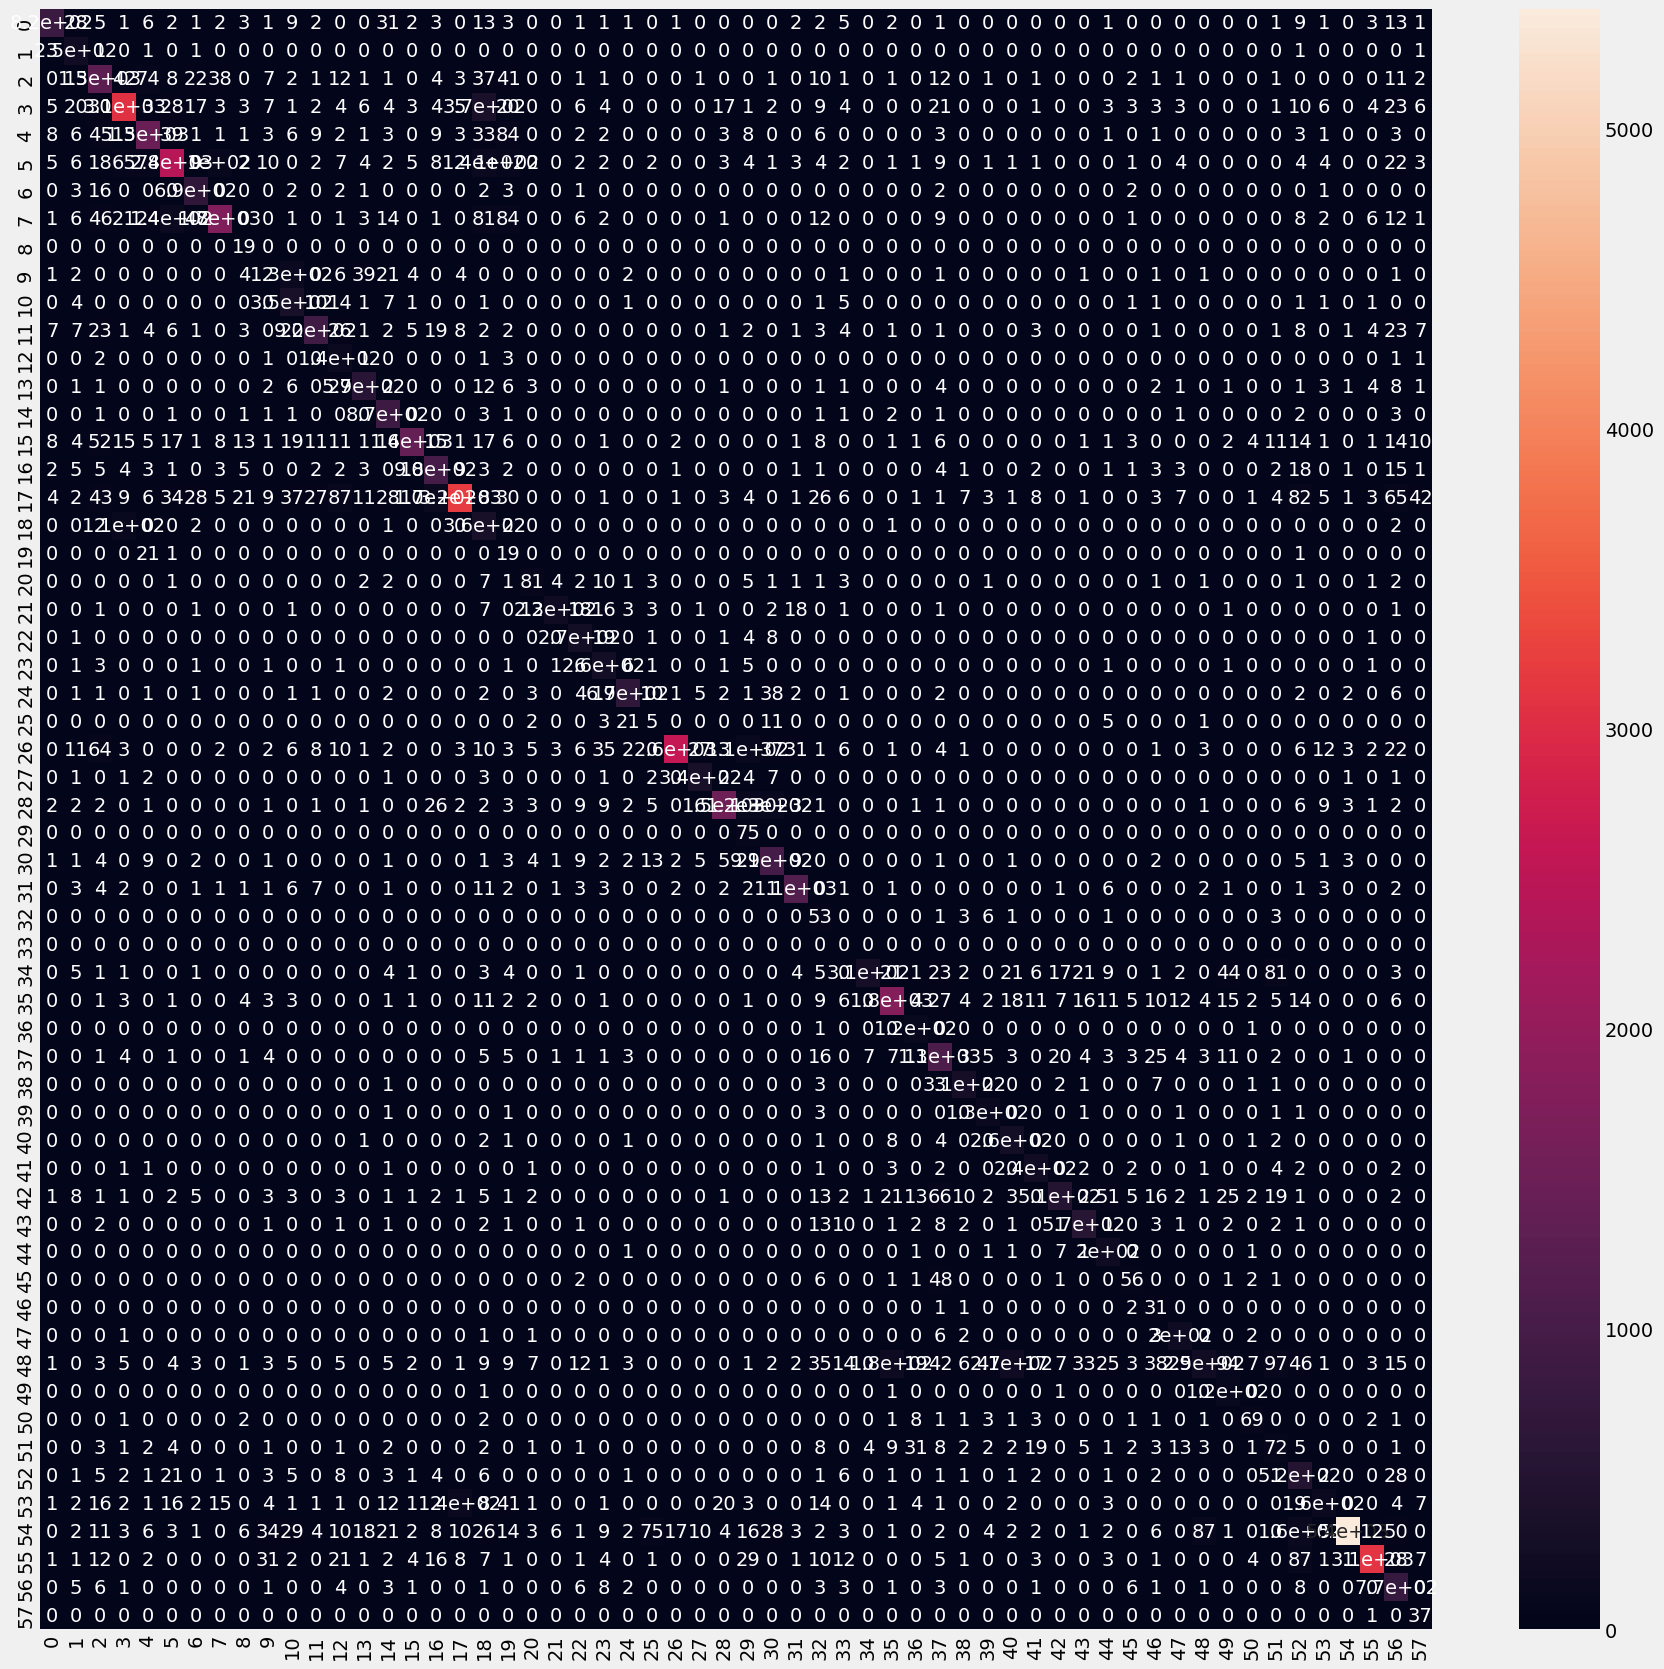

In [ ]:
# Predict test set image
pred=np.argmax(model.predict(X_etest), axis=-1)

eTest_labels_copy = pd.Series(eTest_labels)
labels_test = eTest_labels_copy.value_counts().sort_index().index
labels_pred = pd.DataFrame(pred)[0].value_counts().sort_index().index

result_labels = labels_test.append(labels_pred).value_counts().sort_index().index


#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(eTest_labels_copy, pred)*100)




#confusion matrix
cf = confusion_matrix(eTest_labels_copy, pred)
cf


labels_copy = labels_dict.copy()

#Remove class that does not exist in test set

labels_copy_keys = list(labels_copy.keys())

for i in range(len(labels_copy)):
    if i < len(result_labels):
        while(labels_copy_keys[i] != result_labels[i]):
            del labels_copy[labels_copy_keys[i]]
            del labels_copy_keys[i]



df_cm = pd.DataFrame(cf, index = labels_copy,  columns = labels_copy)
plt.figure(figsize = (20,20)) 
sns.heatmap(df_cm, annot=True)
plt.savefig('CM.png')

print(classification_report(eTest_labels_copy, pred))